In [3]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from PIL import Image, ImageFile
from PIL import ImageDraw
import datasets
from datasets import load_dataset

# Replace 'filename.npz' with your actual .npz file name
file_name = '../data/calcium_data/COSMOS_010reverse.npz'

# Load the .npz file
data = np.load(file_name)

# Get a list of all variables (arrays) in the .npz file
variables = data.keys()
print([(var, data[var].shape) for var in variables])
print("Variables in the .npz file:")
for var in variables:
    df = pd.DataFrame(data[var])
    if(var in ['posvec', 'calcium_signal', 'coordinates', 'dirbin', 'start', 'dirvec', 'tnum', 'epoch']):
        df = df.T
    print(f"{var}: {df.shape} original shape {data[var].shape}")
df_X = pd.DataFrame(data['calcium_signal'])
df_y = pd.DataFrame(data['head_orientation'])
df_y = df_y.T

# X = torch.tensor(df_X.values, dtype=torch.float32)
# y = torch.tensor(df_y.values, dtype=torch.float32)
# epoch = data['epoch']  # shape (1, T) or (T,) possibly
# if epoch.ndim > 1:
#     epoch = epoch.flatten()
    
# # Sanity check: match lengths
# assert len(epoch) == len(df_X), f"Length mismatch: epoch={len(epoch)}, df_X={len(df_X)}"

# # Filter mask for epoch == 3
# mask = (epoch == 3)

# # Apply mask to DataFrames then convert to tensors
# df_X_filtered = df_X[mask]
# df_y_filtered = df_y[mask]

# # Convert to tensors
# X = torch.tensor(df_X_filtered.values, dtype=torch.float32)
# y = torch.tensor(df_y_filtered.values, dtype=torch.float32)

# print(f"Filtered X shape: {X.shape} | Filtered y shape: {y.shape}")
# print(f"X shape: {X.shape}, y shape: {y.shape}")
epoch = data['epoch'].flatten()
epoch = epoch.astype(int)  # in case values are float64 like 3.0

print("Unique epoch values:", np.unique(epoch))  # Debug check

# Mask for epoch == 3
mask = (epoch == 1)

# Check how many entries match
print(f"Matched {mask.sum()} samples with epoch == 3")

# Apply mask
df_X_filtered = df_X[mask]
df_y_filtered = df_y[mask]

# Convert to tensors
X = torch.tensor(df_X_filtered.values, dtype=torch.float32)
y = torch.tensor(df_y_filtered.values, dtype=torch.float32)

print(f"Filtered X shape: {X.shape}, Filtered y shape: {y.shape}")


[('timestamps', (1, 45100)), ('calcium_signal', (45100, 148)), ('coordinates', (45100, 2)), ('head_orientation', (1, 45100)), ('dirbin', (45100,)), ('ttype', (1, 45100)), ('start', (45100,)), ('dirvec', (45100, 8)), ('tnum', (45100,)), ('epoch', (45100,)), ('posvec', (45100, 3))]
Variables in the .npz file:
timestamps: (1, 45100) original shape (1, 45100)
calcium_signal: (148, 45100) original shape (45100, 148)
coordinates: (2, 45100) original shape (45100, 2)
head_orientation: (1, 45100) original shape (1, 45100)
dirbin: (1, 45100) original shape (45100,)
ttype: (1, 45100) original shape (1, 45100)
start: (1, 45100) original shape (45100,)
dirvec: (8, 45100) original shape (45100, 8)
tnum: (1, 45100) original shape (45100,)
epoch: (1, 45100) original shape (45100,)
posvec: (3, 45100) original shape (45100, 3)
Unique epoch values: [0 1 2]
Matched 1875 samples with epoch == 3
Filtered X shape: torch.Size([1875, 148]), Filtered y shape: torch.Size([1875, 1])


In [4]:
# Create dataset and dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)


In [5]:
model = nn.Sequential(
  nn.LazyLinear(128),
  nn.ReLU(),
  nn.LazyLinear(256),
  nn.ReLU(),
  nn.LazyLinear(256),
  nn.ReLU(),
  nn.LazyLinear(64),
  nn.ReLU(),
  nn.LazyLinear(32),
  nn.ReLU(),
  nn.LazyLinear(16),
  nn.ReLU(),
  nn.LazyLinear(1)  # Assuming y has 2 features (e.g., x and y coordinates)
)

# model = nn.Sequential(
#     nn.Unflatten(1, (1, 738)),      # [B, 738] -> [B, 1, 738]
#     nn.Conv1d(1, 32, kernel_size=7, padding=3),  # [B, 1, 738] -> [B, 32, 738]
#     nn.ReLU(),
#     nn.Conv1d(32, 64, kernel_size=5, padding=2), # [B, 64, 738]
#     nn.ReLU(),
#     nn.Conv1d(64, 128, kernel_size=3, padding=1),# [B, 128, 738]
#     nn.ReLU(),
#     nn.AdaptiveAvgPool1d(1),       # [B, 128, 1] (global representation)
#     nn.Flatten(),                  # [B, 128]
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.LazyLinear(256),
#     nn.ReLU(),
#     nn.LazyLinear(256),
#     nn.ReLU(),
#     nn.LazyLinear(64),
#     nn.ReLU(),
#     nn.Linear(64, 1)               # Predict scalar head orientation
# )

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 50  # Set the number of epochs
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        # print(f"Batch X shape: {batch_X.shape}, Batch y shape: {batch_y.shape}, Outputs shape: {outputs.shape}")
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 2.7325
Epoch [2/50], Loss: 3.8762
Epoch [3/50], Loss: 1.5866
Epoch [4/50], Loss: 3.2172
Epoch [5/50], Loss: 0.8317
Epoch [6/50], Loss: 0.5300
Epoch [7/50], Loss: 2.4310
Epoch [8/50], Loss: 1.7170
Epoch [9/50], Loss: 0.3731
Epoch [10/50], Loss: 2.2176
Epoch [11/50], Loss: 1.0096
Epoch [12/50], Loss: 0.4247
Epoch [13/50], Loss: 1.1224
Epoch [14/50], Loss: 0.5692
Epoch [15/50], Loss: 0.2237
Epoch [16/50], Loss: 2.1905
Epoch [17/50], Loss: 0.8573
Epoch [18/50], Loss: 0.7779
Epoch [19/50], Loss: 0.8146
Epoch [20/50], Loss: 0.8084
Epoch [21/50], Loss: 0.2954
Epoch [22/50], Loss: 1.7557
Epoch [23/50], Loss: 1.4453
Epoch [24/50], Loss: 0.5642
Epoch [25/50], Loss: 0.3343
Epoch [26/50], Loss: 0.2468
Epoch [27/50], Loss: 1.1504
Epoch [28/50], Loss: 0.8668
Epoch [29/50], Loss: 0.5882
Epoch [30/50], Loss: 1.2619
Epoch [31/50], Loss: 0.3559
Epoch [32/50], Loss: 0.0358
Epoch [33/50], Loss: 0.5059
Epoch [34/50], Loss: 1.3576
Epoch [35/50], Loss: 0.2162
Epoch [36/50], Loss: 0.0981
E

In [6]:
#evaluate the model
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Average Loss: {avg_loss:.4f}")

Average Loss: 0.3055


ValueError: x and y must have same first dimension, but have shapes (4510,) and (188, 1)

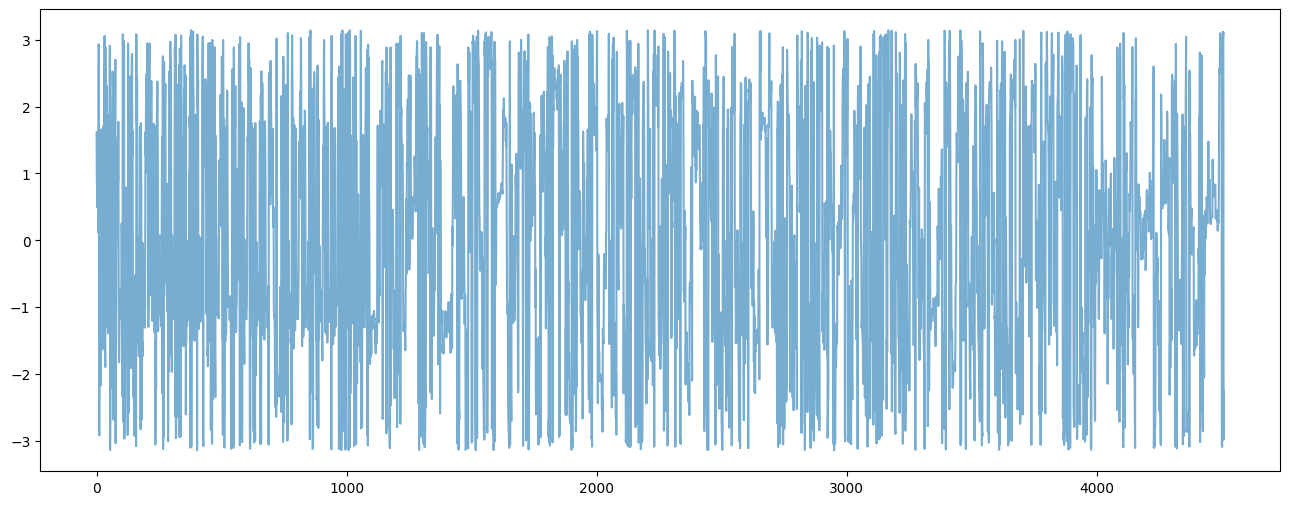

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Select device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Make sure input is on the same device
X_gpu = X.to(device)

# Predict using GPU
model.eval()  # set model to eval mode
with torch.no_grad():
    y_pred = model(X_gpu).cpu().numpy()  # move result back to CPU

# Ground truth
y_true = df_y.values

# Subsample to reduce clutter
stride = 10
y_true_plot = y_true[::stride]
y_pred_plot = y_pred[::stride]
x = np.arange(len(y_true_plot))

# Plot
plt.figure(figsize=(16, 6))
plt.plot(x, y_true_plot, label='True Values', alpha=0.6)
plt.plot(x, y_pred_plot, label='Predicted Values', alpha=0.6)
plt.title('True vs. Predicted Head Orientation')
plt.xlabel('Sample Index')
plt.ylabel('Head Orientation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()